In [2]:
!pip install tensorflow
!pip install matplotlib

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.68.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using 

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Fish",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1029 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['Common Carp', 'Mori', 'Rohu', 'Silver Carp', 'catla']

In [7]:
len(dataset)

33

In [8]:

47*32

1504

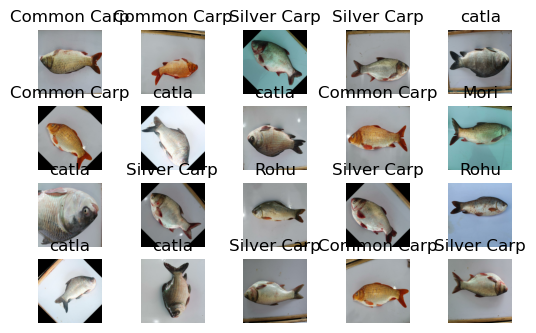

In [9]:


for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:

train_size = 0.8
len(dataset)*train_size

26.400000000000002

In [11]:
train_ds = dataset.take(26)
len(train_ds)

26

In [12]:
test_ds = dataset.skip(26)
len(test_ds)

7

In [13]:
val_size = 0.1
len(dataset)*val_size

3.3000000000000003

In [14]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [15]:
test_ds = test_ds.skip(3)
len(test_ds)

4

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

26

In [19]:
len(val_ds)

3

In [20]:
len(test_ds)

4

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 10
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255),
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

c:\Users\Prathamesh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:

try:
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds
    )
except tf.errors.InvalidArgumentError as e:
    print("InvalidArgumentError occurred during training:", e)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 806ms/step - accuracy: 0.1714 - loss: 2.0591 - val_accuracy: 0.2500 - val_loss: 1.6743
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - accuracy: 0.2300 - loss: 1.6507 - val_accuracy: 0.1458 - val_loss: 1.6752
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.2114 - loss: 1.6406 - val_accuracy: 0.3646 - val_loss: 1.5333
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.3921 - loss: 1.4570 - val_accuracy: 0.3438 - val_loss: 1.3619
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 734ms/step - accuracy: 0.4573 - loss: 1.2783 - val_accuracy: 0.3438 - val_loss: 1.4430
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 734ms/step - accuracy: 0.3911 - loss: 1.3995 - val_accuracy: 0.4688 - val_loss: 1.1823
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 833ms/step - accuracy: 0.5499 - loss: 1.0747 - val_accuracy: 0.5625 - val_loss: 1.1572
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 928ms/step - accuracy: 0.6415 - loss: 0.8755 - val_accu

In [28]:
scores = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.9865 - loss: 0.1636


In [29]:
scores

[0.17164984345436096, 0.984375]

In [30]:
history

In [31]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 26}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

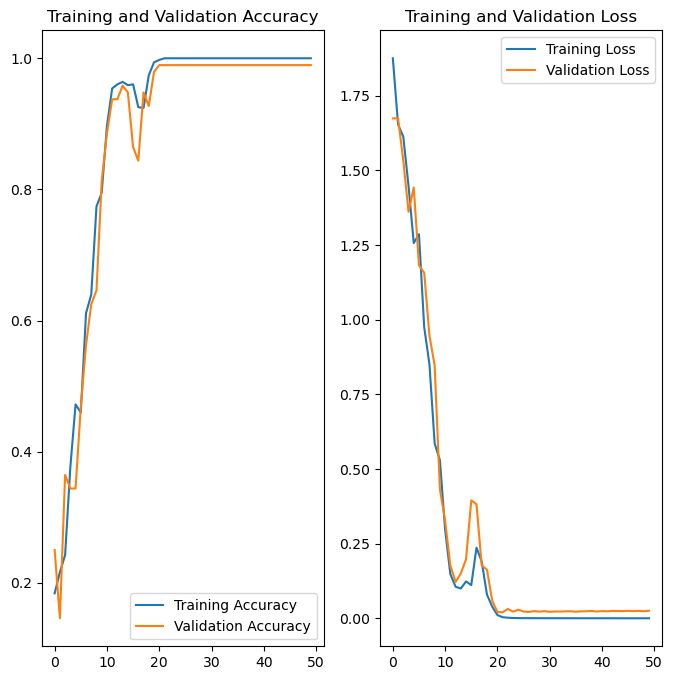

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [35]:
import numpy as np
np.argmax([4.0255643e-13, 1.5018880e-08, 9.9027467e-08, 9.9999630e-01, 2.9897484e-28,
 2.8818323e-22, 2.6648679e-33, 1.2790141e-16, 3.5370842e-06, 2.4498503e-22,
 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.4045852e-36,
 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
 0.0000000e+00, 0.0000000e+00, 1.3216994e-32])

3

tf.Tensor(
[[[[133.75   133.75   131.75  ]
   [133.75   133.75   131.75  ]
   [133.75   133.75   131.75  ]
   ...
   [135.75   129.75   131.75  ]
   [135.75   129.75   131.75  ]
   [135.75   129.75   131.75  ]]

  [[135.     135.5    133.75  ]
   [135.     135.5    133.75  ]
   [135.     135.5    133.75  ]
   ...
   [137.75   134.25   135.25  ]
   [137.75   134.25   135.25  ]
   [137.75   134.25   135.25  ]]

  [[136.     138.     137.    ]
   [136.     138.     137.    ]
   [136.     138.     137.    ]
   ...
   [139.     138.5    138.75  ]
   [139.     138.5    138.75  ]
   [139.     138.5    138.75  ]]

  ...

  [[128.25   127.75   115.9375]
   [133.0625 132.5625 122.0625]
   [117.6875 117.1875 106.6875]
   ...
   [169.875  153.8125 121.125 ]
   [167.5    151.3125 119.75  ]
   [149.1875 133.     101.4375]]

  [[119.     116.25   101.75  ]
   [136.125  133.375  118.875 ]
   [132.375  128.875  116.875 ]
   ...
   [161.6875 134.1875  90.1875]
   [162.875  135.375   91.375 ]
   [149.   

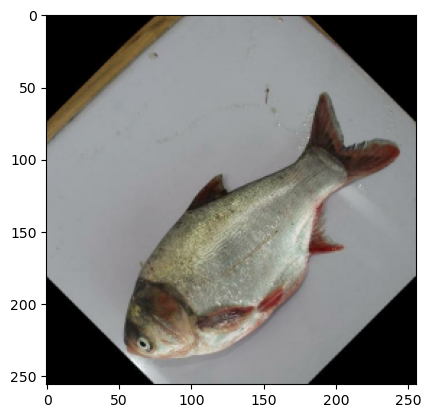

In [36]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print(image_batch)
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [37]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.argmax(predictions[0])),2)
    print(predictions)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
[[2.2907445e-14 5.4539753e-18 1.2001805e-12 9.9999988e-01 1.1087545e-07
  0.0000000e+00 0.0000000e+00 6.6415234e-37 3.4546203e-36 0.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[2.1030636e-11 1.0000000e+00 1.1476446e-09 1.1664800e-17 5.7446571e-26
  5.2969258e-36 4.8343101e-35 1.8443043e-31 2.6558278e-24 0.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[6.4128208e-06 1.7448228e-08 9.9999356e-01 2.2005810e-13 1.8210093e-12
  0.0000000e+00 0.0000000e+00 2.5355723e-34 1.5004419e-29 0.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[7.2933420e-14 9.7366226e-22 6.0057232e-08 4.3505721e-13 9.9999988e-01
  0.0000000e+00 1.9693963e-37 1.0866675e-28 4.2227815e-31 0.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[[8.91160717e-16 1.36873524e-18 2.23873986e-09 9.95319192e-12
  1.00000000e+00 1.06977986e-35 3.61333590e-35 8.18029499e-27
  1.10864502e-29 4.58462763e-38]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[1.0000000e+00 7.9390567e

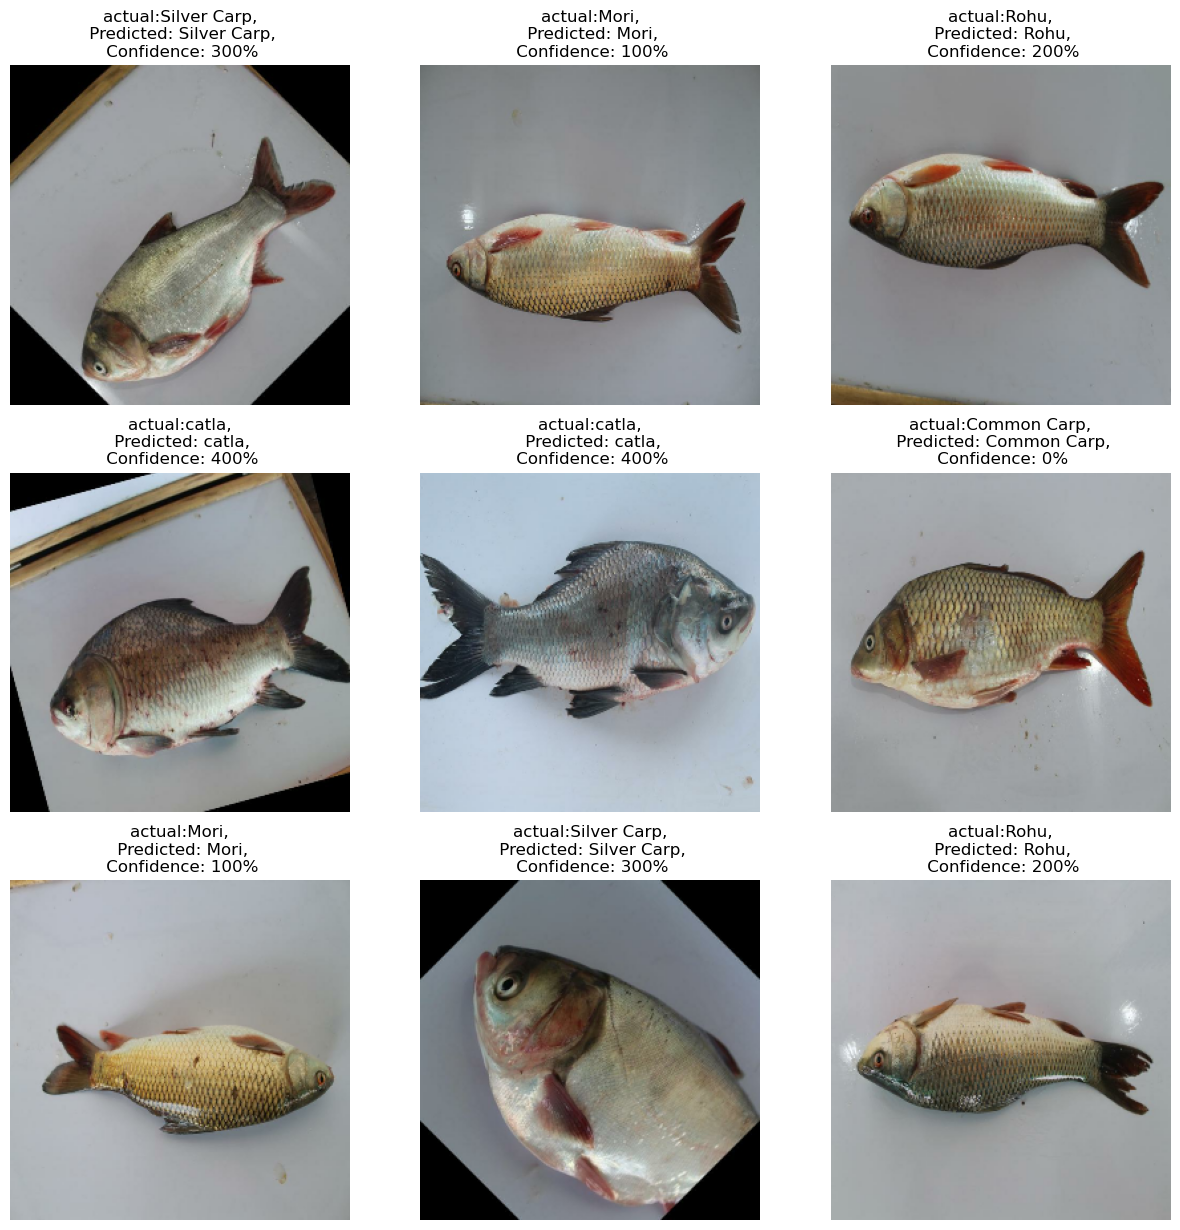

In [38]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class ,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual:{actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis('off')

In [40]:
model.save(f"model.h5")

RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [ ]:

from PIL import Image
img = Image.open("Fish\catla\Catla_1_jpg.rf.eecaba26eac3a5a09fba75bcf9c9fb3e.jpg")

# Resize the image (example: resize to 100x100 pixels)
resized_img = img.resize((256, 256))

# Convert the image to a NumPy array
img_array = np.array(resized_img)
img_array = np.expand_dims(img_array,axis=0)        
print(img_array)

[[[[116 102  93]
   [120 106  95]
   [128 112 102]
   ...
   [122 112 104]
   [122 113 108]
   [122 115 109]]

  [[116 102  93]
   [119 105  94]
   [126 110 100]
   ...
   [123 113 105]
   [123 114 109]
   [123 116 110]]

  [[116 102  93]
   [118 104  94]
   [125 108  98]
   ...
   [123 113 105]
   [123 114 109]
   [122 115 109]]

  ...

  [[187 179 176]
   [194 186 183]
   [203 195 192]
   ...
   [203 195 194]
   [203 197 197]
   [204 198 198]]

  [[198 190 187]
   [204 196 193]
   [212 204 201]
   ...
   [202 195 193]
   [202 196 196]
   [202 196 196]]

  [[206 198 195]
   [212 204 201]
   [217 209 206]
   ...
   [202 195 193]
   [201 195 195]
   [200 194 194]]]]


In [ ]:
model = tf.keras.models.load_model(r'model.h5')
prediction = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


In [ ]:
prediction

array([[2.43540170e-19, 9.99999881e-01, 1.18869427e-15, 1.13049765e-07,
        1.51748968e-14, 1.49518024e-18, 4.48027773e-27, 1.55428121e-15,
        1.92073327e-13, 2.07721118e-10]], dtype=float32)

In [ ]:
predicted_class = dict[np.argmax(prediction)]
print(predicted_class)

dict[1]
